<a href="https://colab.research.google.com/github/LukasBeckers/Transformer_Image_Completion/blob/main/Transformer_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Imports

from google.colab.patches import cv2_imshow
from tensorflow.keras import layers
from glob import glob, escape
from keras.layers import activation
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle as pk
import numpy as np
import shutil
import random
import time
import cv2
import os

In [2]:
# Checking if a GPU is available on the system.

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7299745093946243772
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14417788928
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14210084943639645754
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [3]:
#@markdown # Download the MNIST Dataset
#@markdown The MNIST-dataset was chosen for this project, because my computational recources are very limited and the classical MNIST-dataset is not very computationally intensive.
batch_size = 500 #@param {type:"integer"}

mnist = tfds.load('MNIST', batch_size=batch_size)

train_ds = mnist['train']
test_ds = mnist['test']
print(f'\nNumber of images in the train-subset of the MNIST-dataset: {len(train_ds)*batch_size}')
print(f'Number of images in the test-subset of the MNIST-dataset: {len(test_ds)*batch_size}')

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.

Number of images in the train-subset of the MNIST-dataset: 60000
Number of images in the test-subset of the MNIST-dataset: 10000


Text(0.5, 1.0, 'Test Image')

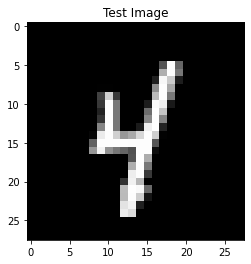

In [4]:
# Testing and Debugging

for test_batch in train_ds:
    break

test_images = test_batch['image']
test_image =  test_images[0]

plt.imshow(test_image[:,:,0], cmap='gray')
plt.title('Test Image')

For this project, I decided to code a transformer model from scratch. 

A transformer-network handles each element of a sequence individually.
A relation between the elements is created in a transformer network via multihead-self-attention.
For this reason, each image must be converted to a sequence of vectors. 
This is done by splitting the images into smaller segments.

In [5]:
def split_image(image, segment_width):
    '''
    This function crops the image, so that the width and the height of the image 
    are divisible by the 'segment_width' parameter. 
    The cropped image is split into square-segments in the size of the 'segment_width'.

    :param image:           image (tf-tensor or np-array) of shape[heigth, width, 1]
    :param segment_width:   Width of the segments-squares that the image will be split into

    :return:                tf-tensor of shape[height//segment_width, width//segment_width, segment_width, segment_width, 1].
                            If the image width or height is not divisible by the segment_width, it will be cropped.
    '''
    # Cropping the image
    image = image[:image.shape[0] // segment_width * segment_width]   # Cropping height
    image = image[:,:image.shape[1] // segment_width * segment_width] # Cropping width
    # Splitting the image.
    # First the width is split, then the height of the image is split.
    image = tf.reshape(image, [image.shape[0],                        # height
                               image.shape[1]//segment_width,         # N_width_segments
                               segment_width,                         # segment_width
                               image.shape[2]                         # 1
                               ])
    image = tf.transpose(image, [1, 0, 2, 3])                         # Swapping height and N_width_segments
    image = tf.reshape(image, [image.shape[0],                        # N_width_segments
                               image.shape[1]//segment_width,         # N_height_segments
                               segment_width,                         # segment_width
                               segment_width,                         # segment_width
                               image.shape[3]                         # 1
                               ])
    image = tf.transpose(image, [1, 0, 2, 3, 4])                      # Swapping N_width_segments and N_height_segments
    # Output shape: [N_height_segments, N_width_segments, segment_width, segment_width, 1]
    return image


The output of the transformer-model will also have the shape of a split-image.
For this reason, a function to reverse the split process is needed.
This function will be able to create normal (non-split) images from split-images.

In [6]:
def unsplit_image(image):
    '''
    This function reverses the split_image function (except the cropping).
    
    :param image:           split RGB-image tf-tensor of shape[N_height_segments, N_width_segments, segment_width, segment_width, RGB]

    :return:                RGB-image-batch tf-tensor of shape[N_images, heigth, width, RGB]
    '''
    image = tf.transpose(image, [1, 0, 2, 3, 4])                      # Swapping N_width_segments and N_height_segments
    image = tf.reshape(image, [image.shape[0],                        # N_width_segments
                               image.shape[1]*image.shape[2],         # N_height_segments * segment_width = height
                               image.shape[3],                        # segment_width
                               image.shape[4]                         # RGB
                               ])
    image = tf.transpose(image, [1, 0, 2, 3])                         # Swapping height and N_width_segments
    image = tf.reshape(image, [image.shape[0],                        # height
                               image.shape[1]*image.shape[2],         # N_width_segments * segment_width = width
                               image.shape[3]                         # RGB
                               ])
    return image

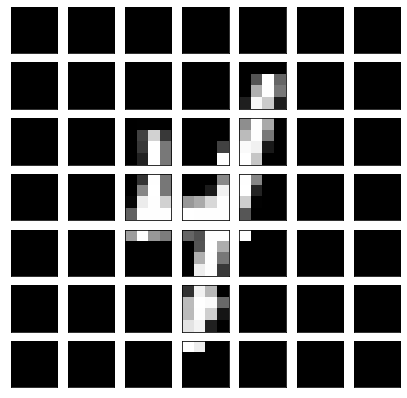

In [7]:
# Testing and Debugging

# Splitting the image.

segment_width = 4
split_test_image = split_image(test_image, segment_width)


# Plotting the split-test-image.
ig, axs = plt.subplots(test_image.shape[0]//segment_width,
                           test_image.shape[1]//segment_width,
                           figsize=[7, 7])

for i_row_g, row_g  in enumerate(axs):
    for i_col_g, col_g in enumerate(row_g):
        col_g.imshow(split_test_image[i_row_g, i_col_g][:,:,0], cmap='gray')

        # Removing the numbers on the axes.
        col_g.set_xticks([])
        col_g.set_yticks([])


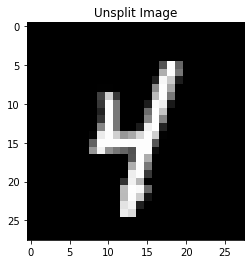

In [8]:
# Testing and Debugging

# Unsplitting the test-image.
unsplit_test_image = unsplit_image(split_test_image)

# Plotting the unsplit test-image.
plt.imshow(unsplit_test_image[:,:,0], cmap='gray')
plt.title('Unsplit Image')
plt.show()

For the training-process, a version of the split image function is needed,
that can split batches of images.

In [9]:
def split_image_batch(batch, segment_width):
    """
    A version of the split_image function that can be applied to batches of images.

    :param batch:   tf.tensor: Batch of images, shape=[batch_size, height, width, RGB]
    :param segment_width: int: Width of the segments-squares that the image will be split into.

    :return:        tf-tensor: Batch of split images, shape = [batch_size, 
                                                               height//segment_width, 
                                                               width//segment_width, 
                                                               segment_width,
                                                               segment_width,
                                                               RGB].
                               If the image width or height is not divisible by the segment_width, it will be cropped.
    """
 
    # Cropping the images.
    batch = batch[:,:batch.shape[1] // segment_width * segment_width]   # Cropping height
    batch = batch[:,:,:batch.shape[2] // segment_width * segment_width] # Cropping width
    # Splitting the images.
    # First the width is split, then the height of the image is split.
    batch = tf.reshape(batch, [batch.shape[0],                          # batch-size
                               batch.shape[1],                          # height
                               batch.shape[2]//segment_width,           # N_width_segments
                               segment_width,                           # segment_width
                               batch.shape[3]                           # RGB
                               ])
    batch = tf.transpose(batch, [0, 2, 1, 3, 4])                        # Swapping height and N_width_segments
    batch = tf.reshape(batch, [batch.shape[0],                          # batch-size
                               batch.shape[1],                          # N_width_segments
                               batch.shape[2]//segment_width,           # N_height_segments
                               segment_width,                           # segment_width
                               segment_width,                           # segment_width
                               batch.shape[4]                           # RGB
                               ])
    batch = tf.transpose(batch, [0, 2, 1, 3, 4, 5])                     # Swapping N_width_segments and N_height_segments
    # Output shape: [batch_size, N_height_segments, N_width_segments, segment_width, segment_width, RGB]
    return batch


def unsplit_batch(batch):
    '''
    This reverses the 'split_image_batch' function, excep for the cropping.
    It will be used to unsplit the output of the model.
    :param batch:           split-images batch tf-tensor of shape[N_images,
                                                                  N_height_segments,
                                                                  N_width_segments,
                                                                  segment_width,
                                                                  segment_width, 
                                                                  RGB]
    :return:                RGB-image batch tf-tensor of shape[N_images, height, width, RGB]
    '''
    batch = tf.transpose(batch, [0, 2, 1, 3, 4])                           # Swapping N_width_segments and N_height_segments
    batch = tf.reshape(batch, [-1,                                         # N_images
                               tf.shape(batch)[1],                         # N_width_segments
                               tf.shape(batch)[2]*tf.shape(batch)[3],      # N_height_segments * segment_width = height
                               tf.shape(batch)[4],                         # segment_width
                               ])  	                                   
    batch = tf.transpose(batch, [0, 2, 1, 3])                              # Swapping height and N_width_segments
    batch = tf.reshape(batch, [-1,                                         # N_images
                               tf.shape(batch)[1],                         # height
                               tf.shape(batch)[2]*tf.shape(batch)[3],      # N_width_segments * segment_width = width
                               ])
    return batch

In [10]:
def flatten_batch(batch):
    '''
    This function can be used inside the call-method of a keras model.
    This function will be used to flatten the image-batches for the transformer-layers in the model.
    :param images: (tf.tensor): Batch of split-images.
                                Shape for batch of images: [batch_size, n_height_segments, n_width_segments, segment_width, segment_width, RGB]

    :return:       (tf.tensor): flattend batch of images.
                                Shape: [batch_size, n_height_segments * n_width_segments, ?]
    '''
    out = tf.reshape(batch, [-1, tf.shape(batch)[1]*tf.shape(batch)[2], tf.shape(batch)[3]*tf.shape(batch)[4]*tf.shape(batch)[5]])
    return out

def unflatten_batch(images, n_height_segments, n_width_segments, segment_width):
    '''
    This function can be used inside the call-method of a keras model.
    This function reverses the flatten operation done to a batch of images by the 'flatten_batch' function
    :param images: (tf.tensor): Batch of flattend RGB-images.
                                Shape: [batch_size, n_height_segments * n_width_segments, ?]

    :return:       (tf.tensor): Batch of split RGB-images.
                                Shape: [batch_size, n_height_segments, n_width_segments, segment_width, segment_width, RGB]
    '''
    out = tf.reshape(images, [-1, n_height_segments, n_width_segments, segment_width, segment_width])
    return out

Now the split_image and the flatten_batch operations are performed on the datasets, 
also the last image segment is dropped from the sequence, because it should be predicted by the model.

In [11]:
def transform_dataset(dataset, segment_width):
    def extract_images(batch):
        batch = tf.cast(batch['image'], tf.float32)
        # Normalizing between 0 and 1
        batch /= 255
        return batch

    def split_image_wrapper(batch):
        image = tf.numpy_function(split_image_batch, [batch, segment_width], tf.float32)
        return image

    def remove_last_element(batch):
        """
        The model will be trained to predict the next image segment of the image
        autoregressively. For this reason the last element of the split- and  
        flattend-images is removed. 
        In the call function of the model, a start token will be added to the 
        start of the image-sequence. This way, the input and target sequence are 
        shifted for on image-segment to each other.
        """
        inputs = batch[:,:-1]
        targets = batch
        return inputs, targets
    dataset = dataset.map(extract_images)
    dataset = dataset.map(split_image_wrapper)
    dataset = dataset.map(flatten_batch)
    dataset = dataset.map(remove_last_element)
    return dataset

In [12]:
#@markdown # Processing the Datasets

segment_width = 4 #@param {type:"integer"}
train_ds_processed = transform_dataset(train_ds, segment_width)
test_ds_processed = transform_dataset(test_ds, segment_width)

In [13]:
# Testing and Debugging

for test_batch in train_ds_processed:
    break

print(test_batch[0].shape, test_batch[1].shape)

(500, 48, 16) (500, 49, 16)


The envisioned transformer-model will be a decoder only model, which will be 
trained autoregressively. 
For this reason a forward facing attention mask will be created in the 
MultiHeadSelfAttention foreward call. 
This mask will prevent the transformer-model from attending to image-semgents 
further forward in the sequence.

In [14]:

class MultiHeadSelfAttention(tf.keras.Model):
    def __init__(self, model_dim, n_heads, dropout_rate=0.1):
        '''
        :param model_dim:       (int): Model dimension.
        :param n_heads:         (int): Number of attention heads
        :param dropout_rate:    (int): dropout_rate used in the Multiheaded attention layer
        '''
        super(MultiHeadSelfAttention, self).__init__()
        assert model_dim % n_heads == 0, f'The dimension of the model must be divisible by the number of used attention heads.\nargs:\n\tnumber of heads: {n_heads}\n\tmodel dimension: {model_dim}\nrest:\t´{model_dim%n_heads}'

        self.model_dim = model_dim
        self.n_heads = n_heads
        # Calculating the head dimension
        self.head_dim = int(model_dim/n_heads)
        # Creating a key, query and value layer for all attention heads
        self.key_layer = layers.Dense(self.head_dim, use_bias=False)
        self.query_layer = layers.Dense(self.head_dim, use_bias=False)
        self.value_layer = layers.Dense(self.head_dim, use_bias=False)
        # Creating a dropout-layer for the linear layers
        self.dropout = layers.Dropout(dropout_rate)
        # Softmax function for the attention matrix
        self.softmax = activation.Softmax(axis=3)

    def call(self, inputs):
        '''
        :param inputs: (tf.tensor): Input Tensor of shape [Batch_size, n_segments, model_dim]
                                    If the multi-head attention object is part of the first transformer layer,
                                    the input is the split and flattended batch of  images with both the width and
                                    height embeddings allready added.

        :return:       (tf.tensor). Output of the multi-head attention object. Shape [Batch_size, n_segments, model_dim]
        '''
        def create_mask(n_segments):
            """
            This function creates a boolean mask for the attention-matrix.
            This mask will be a simple mask which prevents forward attention.

            Example for n_segments=4:

            [[[[True], [False], [False], [False]],    
              [[True], [True],  [False], [False]],
              [[True], [True],  [True],  [False]],
              [[True], [True],  [True],  [True]]
            ]]

            :param n_segments: (int): Number of image-segments of the input of the 
                               'call'-function.

            :return:           (tf-tensor, dtype=bool): Attention maks of shape:[1, 1, n_segments, n_segments]
            """
            mask = tf.linalg.band_part(tf.ones((1, 1, n_segments, n_segments), tf.bool), -1, 0)
            return mask

        # splitting the inputs into the correct number of n_heads_g
        # Reshaping to [Batch_size, n_segments, n_heads, head_dimensions]
        inputs = tf.reshape(inputs, [-1, tf.shape(inputs)[1], self.n_heads, self.head_dim])
        keys = self.key_layer(self.dropout(inputs))
        queries = self.query_layer(self.dropout(inputs))
        values = self.value_layer(self.dropout(inputs))
        # computing the attention-matrix
        # Einsum Function: 'keys'[Batch_size, n_segments, n_heads, head_dimensions],
        # 'queries'[Batch_size, n_segments, n_heads, head_dimensions] -> 'attention_-matrix'[Batch_size, n_heads,
        # n_segments_queries, n_segments_keys]
        attention_matrix = tf.einsum('nqhd, nkhd->nhqk', queries, keys)
        # Scaling the attention matrix by the square-root of the model-dimension.
        attention_matrix /= self.head_dim**0.5
        # Creating the attention-mask.
        attention_mask = create_mask(tf.shape(inputs)[1])
        # Applying the softmax function to the attention matrix.
        attention_matrix = self.softmax(attention_matrix, attention_mask)
        # Using the scaled attention_matrix and applying it to the value tensor.
        # Einsum Function: 'attention_matrix'[Batch_size, n_heads, n_segments_queries, n_segments_keys],
        # 'values'[Batch_size, n_segments_values, n_heads, head_dimensions] -> 'output'[Batch_size, n_segments,
        # n_heads, head_dimensions]
        output = tf.einsum('nhql, nlhd->nqhd', attention_matrix, values)
        #reshaping the output to [Batch_size, n_segments, model_dimensions]
        output = tf.reshape(output, [-1, tf.shape(output)[1], self.model_dim])
        return output



In [15]:
# Testing and Debugging.

# Creating the multiheadselfattention object.
n_heads = 1
model_dimension = 16
multiheadselfattention = MultiHeadSelfAttention(model_dimension, n_heads)

# Loading the input-images.
test_images = test_batch[0]

# Testing the model.
out = multiheadselfattention(test_images)
print(f'Mean value of the output = {tf.reduce_mean(out)}')
print(f'Shape of the output = {out.shape}')

Mean value of the output = -0.01421525701880455
Shape of the output = (500, 48, 16)


Using the MultiHeadAttention class, a transformer-layer class with linear expansion is created.

In [16]:
class TransformerLayer(tf.keras.Model):
    def __init__(self, model_dim, n_heads, linear_expansion, dropout_rate=0.1):
        '''
        :param model_dim:        (int): Dimensions of the model.
        :param n_heads:          (int): Number of attention heads
        :param linear_expansion: (int): During linear expansion, the output will be expanded to
                                        linerar_expansion * model_dim
        :param dropout_rate:     (int): dropout_rate used in the transformer-layer
        '''
        super(TransformerLayer, self).__init__()
        self.model_dim = model_dim
        self.n_heads = n_heads
        self.linear_expansion = linear_expansion
        self.dropout_rate = dropout_rate
        # defining the layers
        self.multi_head_attention = MultiHeadSelfAttention(model_dim = self.model_dim,
                                                           n_heads = self.n_heads,
                                                           dropout_rate=self.dropout_rate)
        self.input_layer = layers.InputLayer(input_shape=(self.model_dim, ))
        self.layer_1 = layers.Dense(self.model_dim*self.linear_expansion, activation='relu')
        self.layer_2 = layers.Dense(self.model_dim, activation='relu')
        self.dropout = layers.Dropout(dropout_rate)
        self.norm1 = layers.BatchNormalization()
        self.norm2 = layers.BatchNormalization()

    def call(self, inputs):
        '''
        :param inputs: (tf.tensor): Input Tensor of shape [Batch_size, n_segments, model_dim]
                                    If the multi-head attention object is part of the first transformer layer,
                                    the input is the split and flattended batch of  images with both the width and
                                    height embeddings allready added.
        :return:       (tf.tensor). Output of the transformer-layer. Shape [Batch_size, n_segments, model_dim]
        '''
        skip_0 = inputs
        out = self.multi_head_attention(inputs)
        # Skip connection to counteract deminishing gradients
        out = self.norm1(out + skip_0)
        skip_1 = out
        out = self.layer_1(self.dropout(out))
        out = self.layer_2(self.dropout(out))
        # Skip connection to counteract deminishing gradients
        out = self.norm2(out + skip_1)
        return out

In [17]:
# Testing and Debugging.

# Creating a transformerlayer object.
n_heads = 1
model_dimension = 16
linear_expansion = 4
transformerlayer = TransformerLayer(model_dimension, n_heads, linear_expansion)

# Loading the input-images.
test_images = test_batch[0]
# Testing the model.
out = transformerlayer(test_images)
print(f'Mean value of the output = {tf.reduce_mean(out)}')
print(f'Shape of the output = {out.shape}')

Mean value of the output = 0.21245361864566803
Shape of the output = (500, 48, 16)


The envisioned transformer model will transform each segment of the image individually.
The model will then attend between the transformed tokens via multiheadattention.
All these steps are not influenced by the order of the image segments in the sequence.
This is unwanted for processing an image, because the order 
of the image-segments obviously matters a lot in a picture.
For this reason to each image-semgent a vector is added, 
which encodes the position of this semgent in the context of the whole image.

Positional Encoding as described in the paper "Attention is all you need"
Doi: arXiv:1706.03762v5 [cs.CL] 6 Dec 2017

In [18]:

class PositionalEncoding():
    '''
    Creates an PositionalEncoding object, with defined maximum sequence length and encoding dimension.
    '''
    def __init__(self, max_length, encoding_dimension):
        '''
        :param max_length:           Maximum position that can be meening-fully encoded.

        :param encoding_dimension:   Dimension of the encoded positions.
                                     This parameter should match the encoding dimension of the transformer model, that is used.
        '''
        self.max_length = max_length                    # Highest encoded position.
        self.encoding_dimension = encoding_dimension    # Output dimension of the positional encoding vector

    def __call__(self, positions):
        '''
        :param positions: An array of positions to encode.
                          All positions should be in form of ints.
                          Example: positions=[0, 1, 3] would return a tensor of shape [3, encoding_dimension]
                          with the encoded positions 0, 1, 3.
        :return:          Tensorflow Tensor of shape [N_positons, encoding_dimension]
        '''
        encoded_positions = np.full([len(positions), self.encoding_dimension],  # 2D np.array of shape [N_positions, encoding_dimensions]
                                    tf.range(self.encoding_dimension),          # filled with numbers from 0...(encoding_dimension-1)
                                    dtype=np.float32)
        encoded_positions = encoded_positions//2                                # all elements of array floor-devided by two
        encoded_positions = self.max_length**(-2
                                              *encoded_positions
                                              /self.encoding_dimension)
        positions_array = np.full([self.encoding_dimension,
                                   len(positions)],
                                  positions)

        positions_array = np.swapaxes(positions_array, 0, 1)
        encoded_positions = encoded_positions * positions_array
        encoded_positions[::2] += np.pi/2                                       # Adding Pi/2 to every odd row, so that sin = cos for odd rows.
        encoded_positions = np.sin(encoded_positions)                           # Calling the sinus function on each element in the array.
        encoded_positions = tf.convert_to_tensor(encoded_positions,             # Converting output to tensorflow tensor.
                                                 dtype=tf.float32)
        return encoded_positions

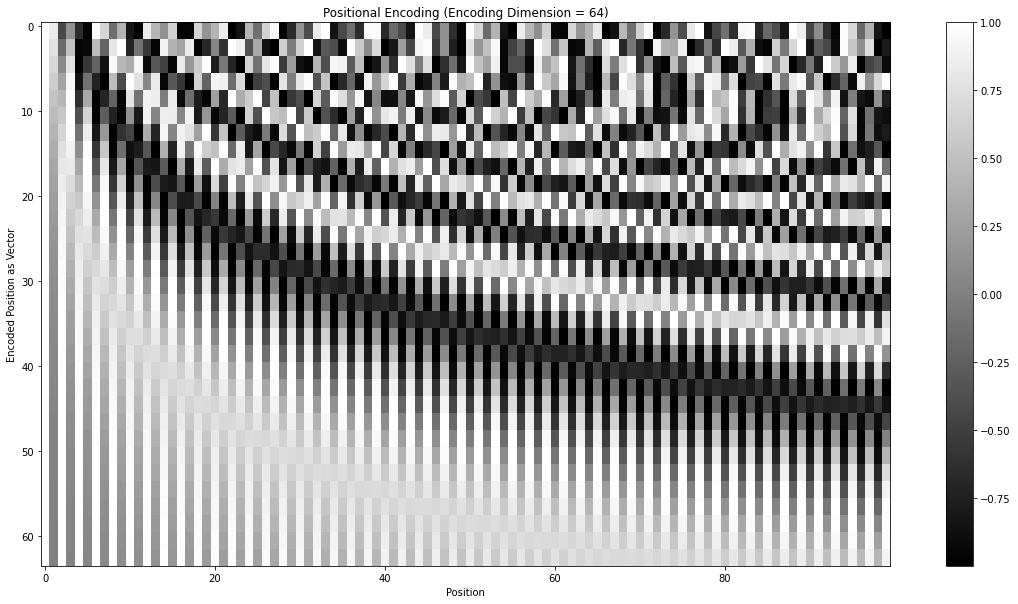

In [19]:
# Testing and Debugging
# Shows the encoded-vectors for 100 successive positions (max_length = 100, encoding_dimension = 64)

max_length = 100
encoding_dimension = 64
n_positions = 100

# Generating the encodings.
test_positional_encoder = PositionalEncoding(max_length, encoding_dimension)
encoded_positions = test_positional_encoder([i for i in range(n_positions)])
image_encoded_positions = tf.transpose(encoded_positions, [1, 0])

# Plotting the Encodings.
fig, axs = plt.subplots(1, figsize=[20, 10])
im = axs.imshow(image_encoded_positions, cmap='gray')
axs.set_xlabel('Position')
axs.set_ylabel('Encoded Position as Vector')
axs.set_title(f'Positional Encoding (Encoding Dimension = {encoding_dimension})')
plt.colorbar(im)
plt.show()

In [20]:
class TransformerModel(tf.keras.Model):
    def __init__(self, model_dim, image_dim, n_heads, linear_expansion, n_layers, segment_width, dropout_rate=0.1, max_length=100):
        '''
        :param model_dim:        (int): Dimensions of the model.
        :param image_dim:        (int): Number of pixels per image-segment.
        :param linear_expansion: (int): During linear expansion in the transformer-layers,
                                        the output will be expanded to linerar_expansion * model_dim
        :param n_heads:          (int): Number of attention heads
        :param n_layers:         (int): Number of layers the model will be comprised of.
        :param segment_width     (int): Width of the segments the image will be split into.
        :param dropout_rate:     (int): Dropout-rate used in the transformer-layer
        '''
        super(TransformerModel, self).__init__()
        self.model_dim = model_dim
        self.image_dim = image_dim
        self.n_heads = n_heads
        self.linear_expansion = linear_expansion
        self.n_layers = n_layers
        self.segment_width = segment_width
        self.dropout_rate = dropout_rate
        self.max_length=max_length

        # creating the positional encoder.
        self.pos_enc = PositionalEncoding(self.max_length, self.model_dim)

        self.norm1 = layers.BatchNormalization()
        # Defining the layers
        self.image_encoding = layers.Dense(self.model_dim)
        self.transformer_layers = []
        for _ in range(self.n_layers):
            self.transformer_layers.append(TransformerLayer(self.model_dim,
                                                self.n_heads,
                                                self.linear_expansion,
                                                self.dropout_rate))

        self.norm_out = layers.BatchNormalization()
        # The output of the model should be a RGB-image of the same size as the input.
        self.output_layer = layers.Dense(self.image_dim, activation='sigmoid')
        # Defining a learnable 'start_sequence_token' 
        self.start_sequence_token = tf.random.uniform([1, 1, self.model_dim])
        

    def call(self, inputs):
        '''
        :param inputs:  (tf.tensor): Batch of images
        :return:       (tf.tensor): Batch of predicted segmentation masks. Shape=[batch_size, N_segments_height, N_segments_width]
        '''
        def add_start_token(inputs):
            """
            This function adds the learnable 'start_sequence_token' to the start 
            of the image-segment seqences.           
            :param inputs:  (tf.tensor): Input of the 'call'-function, flattened
                                         by the 'flatten_batch' function.
                                         shape=[batch_size, n_segments, N_pixels_per_segment]
                                         
            """
            batch_size = inputs.shape[0]
            start_sequence_token = tf.concat([self.start_sequence_token for _ in range(batch_size)], axis=0)
            inputs = tf.concat([start_sequence_token, inputs], axis=1)
            return inputs

        def add_positions(inputs, strength=0.4):
            """
            This function encodes the positions of the image segments, after the 
            'flatten_batch' function.
            :param inputs:   (tf.tensor): Inputs of the call function after flatten batch and image encoding call.
            :param strength: (float): Factor by which the positional encodings are scaled before they are added to the image
            """
            batch_size = inputs.shape[0]
            positions = self.positional_encoding([i for i in range(inputs.shape[1])])
            positions = tf.stack([positions for _ in range(batch_size)])
            positions *= strength
            return inputs + positions

        skip_1 = self.image_encoding(inputs)
        n_segments = tf.shape(skip_1)[1]
        inputs = tf.numpy_function(add_start_token, [skip_1], tf.float32)
        # See reshaping above. Soely for the graph.
        inputs = tf.reshape(inputs, [-1, n_segments+1, self.model_dim])  # n_segments + 1 due to the added start-token

        # Adding skip-connection to allow a gradient flow arround the numpy-functions.
        slice_1 = inputs[:,1:] 
        slice_2 = inputs[:,:1]
        slice_1 += skip_1
        inputs = tf.concat([slice_2, slice_1], axis=1)
        inputs = self.norm1(inputs)

        for layer in self.transformer_layers:
           inputs = layer(inputs)

        inputs = self.norm_out(inputs)
        inputs = self.output_layer(inputs)
        output = inputs
        return output


In [21]:
#@markdown # Here the model is defined.
model_dimension = 400 #@param {type:"integer"}
segment_width = segment_width             # Must be identical to the segment widht used in the dataset!
image_dim = segment_width**2
n_heads = 4 #@param {type:"integer"}
linear_expansion = 2 #@param {type:"integer"}
n_layers = 3 #@param {type:"integer"}
dropout_rate = 0.2 #@param {type:"number"}
max_length = 100 #@param {type:"integer"}


model = TransformerModel(model_dimension,
                         image_dim,
                         n_heads,
                         linear_expansion,
                         n_layers,
                         segment_width,
                         dropout_rate, 
                         max_length)

In [22]:
# Testing and Debugging

# Loading the input-images.
out = model.predict(test_batch[0])
print('Shape of the output = ', out.shape)
print(f'Mean value of the output = {tf.reduce_mean(out)}')

16/16 [==============================] - 2s 16ms/step
Shape of the output =  (500, 49, 16)
Mean value of the output = 0.5117594003677368


In [23]:
# Defining the loss-function.
loss_function = tf.keras.losses.MeanSquaredError()

In [24]:
# Compiling the model.
model.compile(tf.keras.optimizers.Adam(learning_rate=1e-4), loss=loss_function)

In [25]:
#@markdown Creating a custom callback, that is called after every epoch. This callback saves the model's weights if a new best val_loss is found.

#@markdown Connecting the notebook to your google-drive!

from google.colab import drive
drive.mount('/content/drive')

#@markdown Path to your model checkpoint dir:
model_path = "/content/drive/MyDrive/Colab Notebooks/Transformer_Image_Completion/model_checkpoints/Weights" #@param {type:"string"}

class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, model_path):
        self.model_path = model_path
        self.min_loss = 10**100

    def on_epoch_end(self, epoch, logs=None):
        val_loss = logs['val_loss']
        if val_loss < self.min_loss:
            self.min_loss = val_loss
            model.save_weights(self.model_path)

my_callback = CustomCallback(model_path)

#@markdown The saved model-checkpoint will be loaded, if the training was already started in a previous session.

try:
    model.load_weights(model_path)
    print('Loaded model from checkpoint')
except Exception: pass

Mounted at /content/drive
Loaded model from checkpoint


In [26]:
#@markdown # Training the model
epochs = 250 #@param {type:"integer"}
history = model.fit(train_ds_processed, validation_data=test_ds_processed, epochs=epochs, callbacks=[my_callback])

Epoch 1/250
120/120 [==============================] - 39s 296ms/step - loss: 0.0327 - val_loss: 0.0492
Epoch 2/250
120/120 [==============================] - 33s 276ms/step - loss: 0.0322 - val_loss: 0.0481
Epoch 3/250
120/120 [==============================] - 34s 283ms/step - loss: 0.0321 - val_loss: 0.0474
Epoch 4/250
120/120 [==============================] - 34s 280ms/step - loss: 0.0318 - val_loss: 0.0454
Epoch 5/250
120/120 [==============================] - 34s 279ms/step - loss: 0.0316 - val_loss: 0.0414
Epoch 6/250
120/120 [==============================] - 34s 280ms/step - loss: 0.0315 - val_loss: 0.0397
Epoch 7/250
120/120 [==============================] - 34s 280ms/step - loss: 0.0313 - val_loss: 0.0393
Epoch 8/250
120/120 [==============================] - 34s 280ms/step - loss: 0.0312 - val_loss: 0.0385
Epoch 9/250
120/120 [==============================] - 34s 280ms/step - loss: 0.0312 - val_loss: 0.0377
Epoch 10/250
120/120 [==============================] - 33s 278m

KeyboardInterrupt: ignored